## See DeepLizard:
    https://deeplizard.com/learn/video/jkdXDinWfo8

# The alogrithme of DQN:

1. Initialize replay memory capacity.
2. Initialize the policy network with random weights.
3. Clone the policy network, and call it the target network.
4. For each episode
    1. Initialize the starting state.
    2. For each time step : 
        1. Select an action :
            - Via exploration or exploitation
        2. Execute selected action in an emulator.
        3. Observe reward and next state.
        4. Store experience in replay memory.
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values.
        9. Requires a pass to the target network for the next state
        10. Gradient descent updates weights in the policy network to minimize loss.
        11. After  time steps, weights in the target network are updated to the weights in the policy network.

# 1) Import:

In [3]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  #--------
from collections import namedtuple  #--------
from itertools import count #--------
from PIL import Image #--------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  
from torchsummary import summary


import time
#from IPython.display import clear_output
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: 
    from IPython import display
    print('from IPython, display is imported')
    
    
print('Imported ...')


from IPython, display is imported
Imported ...


# 2) Define Some Classes:
## 2.1 Define the DQN class:

In [14]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width) :
        super().__init__()
        
        self.l1 = nn.Linear(in_features = img_height*img_width*3, out_features = 24)
        self.l2 = nn.Linear(in_features =24, out_features = 32)
        self.out= nn.Linear(in_features = 32, out_features = 2)
    
    def forward(self,t):
        t = t.flatten(start_dim = 1)
        t = F.relu(self.l1(t))
        t = F.relu(self.l2(t))
        t = self.out(t)
        
        return t

class DQN2(nn.Module):
  def __init__(self,h,w):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5)
    # o = (28-5+2*0)/1 + 1 = 24 # Conv2
    # o =(24-2+2*0)/2+1 = 12 # MaxPooling

    self.oh = (h-5+2*0)/1 + 1 # # Conv2
    self.oh =(self.oh-2+2*0)/2+1 #= 12 # MaxPooling
    self.ow = (w-5+2*0)/1 + 1 # # Conv2
    self.ow =(self.ow-2+2*0)/2+1 #= 12 # MaxPooling
    self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 12, kernel_size= 5)
    # o =(12 - 5 +0*2)/1 + 1 = 8 # Conv2
    # o = (8 - 2 +0)/2 +1 = 4
    self.oh = (self.oh-5+2*0)/1 + 1 # # Conv2
    self.oh = int( (self.oh-2+2*0)/2+1 ) #= 12 # MaxPooling
    self.ow = (self.ow-5+2*0)/1 + 1 # # Conv2
    self.ow =int( (self.ow-2+2*0)/2+1 ) #= 12 # MaxPooling

    print(self.oh, self.ow)

    self.fc1 = nn.Linear(in_features= 12*self.oh*self.ow, out_features= 120)
    self.fc2 = nn.Linear(in_features= 120, out_features= 60)
    self.out = nn.Linear(in_features = 60, out_features=2)
    #Note: Dense, Fully Connected, Linear refer to the same type of layer

  def forward(self,t):
    #t = self.layer(t)

    # 1 input layer:
    t = t

    # 2 hidden conv layer
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size = 2, stride = 2)

    # 3 hidden conv layer
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t,kernel_size = 2, stride = 2 )

    # flatten the layer:
    t = t.reshape(-1 , 12*self.oh*self.ow)

    # 4 hidden fc layer
    t = self.fc1(t)
    t = F.relu(t)

    #5 hidden fc layer:
    t = self.fc2(t)
    t = F.relu(t)

    #6 hidden out layer:
    out = self.out(t)
    out = F.softmax(out)
    return  out

model = DQN(28,28)#.cuda

print('finished ...')  

finished ...


## 2.2 Define the experience tuple:

In [20]:
Experience = namedtuple('experience',  ( 'state','action','reward','next_state') )
e = Experience(1,3,3,4)
print(e.state)
?e

1


Type:        experience
String form: experience(state=1, action=3, reward=3, next_state=4)
Length:      4
Docstring:   experience(state, action, reward, next_state)


## 2.3 Replay Memory:
Now that we have our Experience class, let's define our ReplayMemory class, which is where these experiences will be stored.


In [21]:
class replaymemory():
    
    # define the memory parameters:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    # feeding function
    
    def push(self, experience):
        #if self.push_count < self.capacity:
        if len(self.memory) < self.capacity :
            self.memory.append(experience)
        else :
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    # outputting function:
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size 
    
        #print(random.sample(range(10),3))

print('finished ...')  

finished ...


## 2.4 Epsilon Greedy Strategy :

In [22]:
class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay 
        self.history = []
    
    def get_exploration_rate(self, episode):
        rate = self.end + (self.start -self.end )*np.exp(-self.decay*episode)
        self.history.append(rate)
        return rate

print('finished ...')  

finished ...


## 2.5 Reinforcement Learning Agent Class:

In [23]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.num_actions = num_actions
        self.strategy = strategy
        self.current_steps = 0
        self.device = device
        
    # trade off: exploration vs exploiation
    def decide(self, policy_net, state): 
        rate =  self.strategy.get_exploration_rate(self.current_steps)
        self.current_steps += 1 
        
        if rate > random.random(): # explore
            action = random.randrange(self.num_actions)
            action = torch.tensor([action]).to(self.device)
            decision = 'exploration'
            
        else : # otherwise eploite:
            with torch.no_grad(): 
                action = policy_net(state).argmax(dim=1).to(self.device) #policy_net(self.state).argmax(dim=1).item()
            decision = 'exploitation'
                
        return action, decision
    
print('finished ...')  

finished ...


## 2.6 Environement Manager:

In [24]:
class CartPolEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.done =  False
        self.current_screen = None
    
    # wrapped functions ---------------------
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
       # ----  
   
    # number of actions ----------------------------
    def num_actions(self):
        return self.env.action_space.n
    
    # Execute an action :
    def step(self,action):
        _ ,reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward],device = self.device)
        
    # strating an episode:----------------------------
    def just_starting(self):
        return self.current_screen is None
    
    # Getting the state of the env:-----------------
    def get_state(self): # he point of this function is to return the current state of the environment in the form of a processed image of the screen      
        if self.just_starting() or self.done :
            self.current_screen = self.get_processed_screen()
            return torch.zeros_like(self.current_screen) # black image
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            velocity_screen =  (s2 - s1) 
            self.current_screen = s2
            return velocity_screen
        
    # Get Processed Image Dimensions:---------------------
    def get_screen_height(self):
        screen = self.get_processed_screen()
        #self.close()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        #self.close()
        return screen.shape[3]      
    
    # Processing the Image:**************************************
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) # Pytotch DQN experct C H W
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    # crop screen:
    def crop_screen(self, screen):
        h = screen.shape[1]
        
        top = int(h*0.4)
        bottom = int(h*0.8)
        
        return screen[:,top:bottom,:]
    
    # Convert and rescale the screen shot:
    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype = np.float32 )/255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose( [ 
            T.ToPILImage(),
            T.Resize((40,90)), 
            T.ToTensor() 
        ] )
        return resize(screen).unsqueeze(0).to(self.device)

print('finished ...')

finished ...


### 2.7 Test processed image:

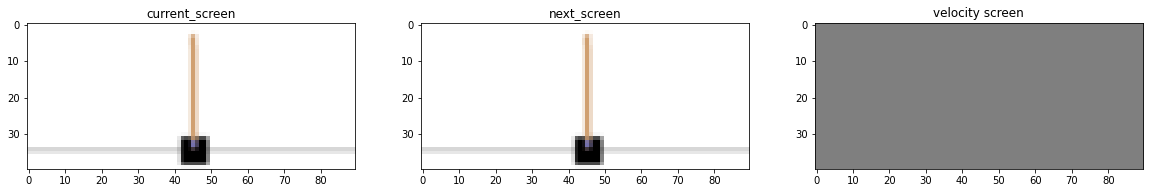

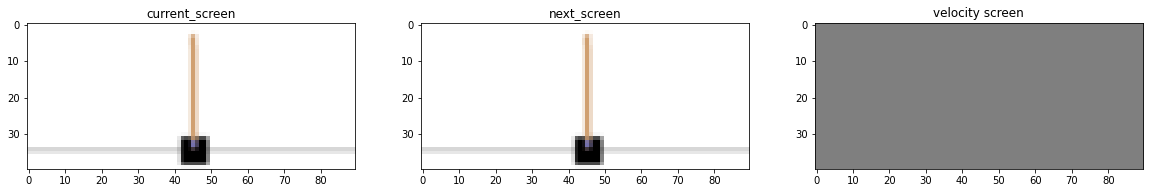

finished ...


In [25]:
def show_state(episode, step, em):
        
   # reward  = em.step(1)
    #print('step: ', step, ' |  reward: ', reward.item() , '  |  end or start : ', em.just_starting() or em.done)
    fig, [ax1, ax2, ax3 ] = plt.subplots(1, 3, figsize=(20, 6))

    screen = em.current_screen
    ax1.imshow(screen.squeeze(0).permute(1, 2, 0).cpu())
    ax1.set_title('current_screen')


    screen = em.get_processed_screen()
    ax2.imshow(screen.squeeze(0).permute(1, 2, 0).cpu())
    ax2.set_title('next_screen')

    screen = em.get_state()
    ax3.imshow(screen.squeeze(0).permute(1, 2, 0).cpu()+0.5)
    ax3.set_title('velocity screen')
    plt.show()
    
    plt.pause(.01)

#####################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em =  CartPolEnvManager(device)
em.reset()

em.render('rgb_array')
em.get_state()

for i in range(2):
    
    #em.step({0})
    show_state(1, i, em)
    
    if em.done == True :
        em.reset()
        em.get_state()

    #plt.pause(.01)
    #if is_ipython: display.clear_output(wait=True)
        
em.close()




print('finished ...')

In [26]:
em.close()

# 3) Define some functions:
## 3.1 Tensor exrators

In [27]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    
#     print('batch.action', batch.action)
#     print('batch.next_state', batch.next_state)
#     print('batch.reward', batch.reward)

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

## 3.2 QValues class

In [28]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current_qvalues(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod        
    def get_next_qvalues(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values    
    

## 3.3 PLOT function:

In [29]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

## 3.4 Progression function:

In [30]:
# Progress bar function:
def update_progress(what,i,imax, redraw=False):
    """
    Display a text progress bar, as :
    My progress bar : ############# 34%
    args:
        what  : Progress bas name
        i     : Current progress
        imax  : Max val
        
        #
        ue for i
    return:
        nothing
    """
    bar_length = min(40,imax)
    if (i%int(imax/bar_length))!=0 and i<imax and not redraw:
        return
    progress  = float(i/imax)
    block     = int(round(bar_length * progress))
    endofline = '\r' if progress<1 else '\n'
    text = "{:16s} [{}] {:>5.1f}% of {}".format( what, "#"*block+"-"*(bar_length-block), progress*100, imax)
    print(text, end=endofline)

# 3) Main Program

## 3.1 hyperparameters:

In [31]:
batch_size = 256
gamma = 0.9 # it is the 0.999 that made me crazy :P 
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
net_learning_rate = 0.001
num_episodes = 1000

print('finished ...')

finished ...


## 3.2 Essentiel Objects :

In [32]:
# setup the device :
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the environement manager:
em = CartPolEnvManager(device)

# strategy (exploration rate updater)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

# Agent:
agent = Agent(strategy, em.num_actions(), device)

# Memory:
memory = replaymemory(memory_size)

# Target Network and Policy Network:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)  # target_net =  policy_net
# --
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
# set the optimizer :
optimizer = optim.Adam(params = policy_net.parameters(), lr = net_learning_rate)

em.close()
print('>>> finished ...')

>>> finished ...


## 3.3 Training Loop :

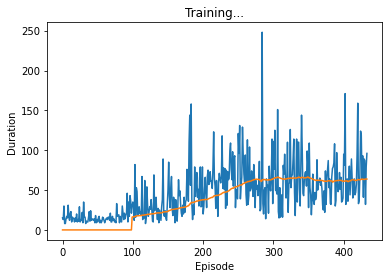

Episode 434 
 100 episode moving avg: 63.77


In [ ]:
# array to store episode durations during training in order to plot them using the plot():
episodes_durations = []
#em.get_state()
for episode in range(num_episodes): # 4 for each episode
    em.reset()
    state = em.get_state() # A) initialize the starting state
    
    for step in count():#range(20): #count(): # B) for each step:
        # show the progression:
        #print('Episode: ', episode, '| Step: ', step)
        
        action, decision = agent.decide(policy_net,state) # a. let the agetn select an action based on the exploration rate
        #print(action)
        reward = em.step(action) # b. execute the agent selected decision.
        new_state = em.get_state()   # c. observe reward and next state
        experience =  Experience(state, action, reward, new_state)
        memory.push(experience) # d. store the experience in the reaplay memory
        state = new_state # update for the next upcoming step.
        ## Learn from the stored experiences: 
        if memory.can_provide_sample(batch_size) :
            batch =  memory.sample(batch_size)  #  e. Sample random batch from replay memory.
            states, actions, rewards, next_states = extract_tensors(batch) # f...
            
            current_qvalues = QValues.get_current_qvalues(policy_net, states, actions) # g. Pass batch of preprocessed states to POLICY network.
            next_qvalues = QValues.get_next_qvalues(target_net,next_states) # g2. Pass batch of preprocessed states to TARGET network.
            target_qvalues = rewards + gamma*next_qvalues 
            
            loss = F.mse_loss(current_qvalues, target_qvalues.unsqueeze(1)) # h. the loss between target q-values and output q-values 
            optimizer.zero_grad() # i. backpropagation process
            loss.backward()
            optimizer.step()
                

        #display.clear_output(wait=True)
        
        if em.done :
            episodes_durations.append(step)
            plot(episodes_durations,100)
            break
        
        # show the state:
        #show_state(episode, step, em)
        #update_progress('Episodes: ', episode , num_episodes)
        
    if episode % target_update == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()
        
print('>>> finished ...')
#print(len(memory.memory))

10939


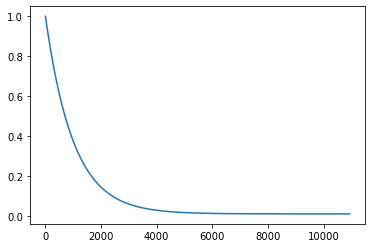

In [53]:
print(agent.current_steps)
plt.plot(strategy.history)

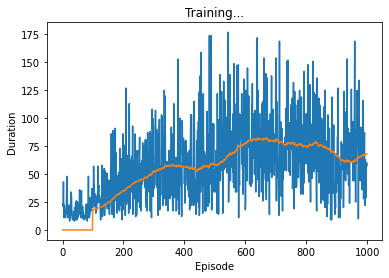

Episode 1000 
 100 episode moving avg: 67.92


In [23]:
plot(episodes_durations,100)
